# Stereo 3D Reconstruction

### Main Steps

1. Camera calibration.
2. Undistort pictures: Use the parameters from step 1 to undistort pictures.
3. Feature matching: Find similar features between images and then build a depth map.
4. Projection: When we get the depth map, we can project points from 2D pictures into 3D space.
5. Build point cloud: Put the points of 3D space into a file and use the file to show the result.
6. Build 3D model: Use the point cloud we get from step 5 to build mesh to get real 3D model.

### Feature Matching

##### Part I

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from scipy.ndimage import filters


# load picture(argument: path of the picture)
def load_pic(path):
    return np.array(Image.open(path))

# load picture as gray image(argument: path of the picture)
def load_pic_as_gray(path):
    return np.array(Image.open(path).convert('L'))


# calculate each value of pixel by kernel and image (multiply kernel and image,then calculate the sum of them)
# and limit each value range of pixel to 0-255
# arguments:array of image and kernel
def normalize(image, kernel):
    ans = np.sum(np.multiply(image, kernel))
    if ans > 255:
        return 255
    else:
        return ans


# use normalize function to calculate each value of pixel and put them into a new array
# arguments:array of image and kernel
def convolution(image, kernel):
    h_kernel, w_kernel = kernel.shape
    h_image, w_image = image.shape
    h_pic = h_image - h_kernel + 1
    w_pic = w_image - w_kernel + 1
    pic = np.zeros((h_pic, w_pic), dtype=np.int32)

    for i in range(h_pic):
        for j in range(w_pic):
            pic[i, j] = normalize(image[i:i + h_kernel, j:j + w_kernel], kernel)
    return pic


# Because of the size of kernel,we can't deal with some rows of pixels of picture.
# Therefore I fill the border of the picture with 0.
# And the length of border is half of width of kernel or half of height of kernel
# arguments:array of image and kernel
def padding(image, kernel, color):
    h_kernel, w_kernel = kernel.shape
    h_kernel //= 2
    w_kernel //= 2
    return np.pad(image, ((h_kernel, h_kernel), (w_kernel, w_kernel)), 'constant',constant_values=(color, color))


# calculate the final result
# 1.we should load the picture first and then fill the boundry
# 2.calculating convolutions respectively.
# arguments:gray image and kernel
def final(img_gray, kernel):

    img_gray = padding(img_gray, kernel, 0)

    img_new = convolution(img_gray, kernel)

    return img_new


#calculate auto-correlation Matrix A
#arguments: gray image, kernel in X direction, kernel in Y direction
def auto_correlation_matrix_a(image_gray, kernel_x, kernel_y, sigma=1):

    #Filtering in X direction
    i_x = final(image_gray, kernel_x)
    
    #Filtering in X direction
    i_y = final(image_gray, kernel_y)

    #calculate Ixx, Ixy, Iyy and then using Gaussian smooth filter to eliminate unnecessary outliers and bulges
    i_xx = filters.gaussian_filter(i_x*i_x, sigma)
    i_xy = filters.gaussian_filter(i_x*i_y, sigma)
    i_yy = filters.gaussian_filter(i_y*i_y, sigma)

    # determinant and trace
    det = i_xx*i_yy - i_xy**2
    trace = i_xx + i_yy

    #equation 4.9 in Szeliski
    return det - 0.06 * trace**2

# caclulate feature locations
# arguments: R (related to Matrix A), threshold
def feature_locations(r, threshold, min_dist=10):

    # find top corner candidates above a threshold
    corner_threshold = r.max() * threshold

    # get coordinates of candidates
    coordinates = np.array((r > corner_threshold).nonzero()).T

    # get values of candidates
    candidate_values = [r[c[0], c[1]] for c in coordinates]

    # sort candidates and get indexes of them ()
    indexes_of_candidates = np.argsort(candidate_values)[::-1]

    # store allowed point locations in array, 1 is allowed.
    # In order to avoid points on boundary of the image being detected as features, we need to set the points on the
    # boundary into 0.
    locations = np.zeros(r.shape)
    locations[min_dist:-min_dist, min_dist:-min_dist] = 1

    # select points
    points = []
    for i in indexes_of_candidates:
        if locations[coordinates[i, 0], coordinates[i, 1]] == 1:
            points.append(coordinates[i])
            # In order to find the max value in a region, we only need to get the max value of this region and remove others.
            # for example, in a min_dist*min_dist region, only the first value (because we sort them into descending order
            # before) is the value we want and we must set others into 0.
            locations[(coordinates[i, 0]-min_dist):(coordinates[i, 0]+min_dist),
            (coordinates[i, 1]-min_dist):(coordinates[i, 1]+min_dist)] = 0

    return points

# We only need image, kernels and threshold to get feature locations
def detect_features(img, kernel_x, kernel_y, threshold):
    R = auto_correlation_matrix_a(img, kernel_1, kernel_2)
    return feature_locations(R, threshold)
          

##### Part II (feature matching)

In this part, I want to implement simple feature descriptors and establish some preliminary feature matches between two images, so that I can see whether my detector can work well.

There many matching strategies and the simplest one is Euclidean (vector magnitude) distances in feature space. However, in this case, I select another more complicated but more accurate algorithm: Normalized Cross Correlation (NCC). The range of NCC is from -1 to 1 inclusive. For the images, each pixel can be seen as a value, so the whole image can be regarded as a collection of data. If one data matches with another data, its NCC value is 1, which means a high correlation. If it is -1, it means that they are totally irrelevant. The NCC formular:

$$NCC = \frac{1}{n - 1}\sum_{x, y}\frac{(f(x, y) - \mu_f)(t(x, y) - \mu_t)}{\sigma _f \sigma _t}$$


In [4]:
# generate descriptors
def descriptors(image, locations, length = 5):
 
    # to generate simple descriptors, I just take length * length regions as descriptors.
    # but the outcome is pretty good (see the images below)
    desc = []
    for loc in locations:
        region = image[loc[0]-length:loc[0]+length+1,loc[1]-length:loc[1]+length+1].flatten()
        desc.append(region)

    return desc

# match descs from two images
def match(desc1, desc2, threshold):

    n = len(desc1[0])

    # set all values to -1, which means they are totally irrelevant at the beginning
    ncc_matrix = -np.ones((len(desc1),len(desc2)))
    
    # calculate NCC
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - np.mean(desc1[i])) / np.std(desc1[i])
            d2 = (desc2[j] - np.mean(desc2[j])) / np.std(desc2[j])
            ncc_value = sum(d1 * d2) / (n-1)
            # set threshold
            if ncc_value > threshold:
                ncc_matrix[i,j] = ncc_value

    # get indexes of all NCCs in ascending order
    indexes = np.argsort(ncc_matrix)

    # get the indexes of the max ncc values.
    max_idx = indexes[:,-1]

    return max_idx


# if the answer we match image1 with image2 is the same with the answer we match image2 with image1, it can be selected.
def match_index(desc1, desc2, threshold = 0.5):

    match_12 = match(desc1,desc2,threshold)
    match_21 = match(desc2,desc1,threshold)

    # get indexes of answers of match_12
    index_12 = np.where(match_12 >= 0)[0]

    # remove matches that are not the same
    for i in index_12:
        if match_21[match_12[i]] != i:
            match_12[i] = -1

    return match_12

# resize an image and pad it.
def resize(image,size):
    
    new_image = np.zeros(image.shape)
    img = Image.fromarray(np.uint8(image))
    new_image[:size[1], :size[0]] = np.array(img.resize(size))
    
    return new_image

# draw lines between matched locations
def draw_matches(image1, image2, locations1, locations2, indexes):


    img = np.hstack([image1, image2])
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    
    plt.imshow(img, cmap = 'gray')
   
    # draw lines between matched locations 
    for i,m in enumerate(indexes):
        if m>0:
            plt.plot([locations1[i][1],locations2[m][1]+image1.shape[1]],[locations1[i][0],locations2[m][0]],'c')
            
    plt.show()

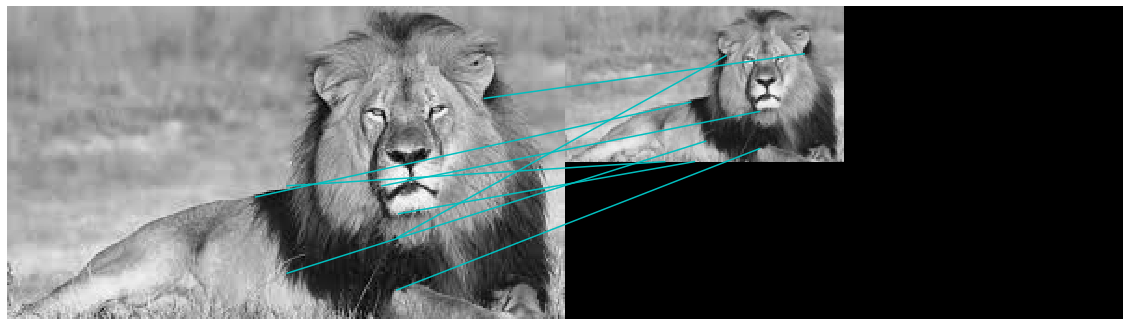

In [6]:
p = 'lion.jfif'

# kernel in x direction
kernel_1 = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
# kernel in y direction
kernel_2 = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])

# load images
img1 = load_pic_as_gray(p)
img2 = load_pic_as_gray(p)

# resize image
img2 = resize(img2, (img2.shape[1]//2, img2.shape[0]//2))

# get locations and descriptors from two images
locations1 = detect_features(img1, kernel_1, kernel_2, 0.1)
desc1 = descriptors(img1, locations1, 5)

locations2 = detect_features(img2, kernel_1, kernel_2, 0.1)
desc2 = descriptors(img2, locations2, 5)

# get all the matches
matches = match_index(desc1, desc2, 0.5)


draw_matches(img1, img2, locations1, locations2, matches)

The performance is really good. It just has two error: one is the left ear and the other is the chin. However, my goal is to generate depth map (in Stereo Reconstruction I need to generate disparity map) and it is difficult for this method to generate enough feature pairs to generate a disparity map. Therefore, I decide to use another popular method to try to generate a disparity map again. Although the first method is fail, I learn a lot, so I put it in my project draft.

#### Sum of Absolute Differences

If we use some professional equipments, it is easier for us to get depth map. Take Kinect camera as an example, Kinect camera uses infrared sensors combined with RGB cameras, it means that this camera gets information from the infrared sensor, which means Kinect camera can get a depth map almost right away. However, we only have phone camera, we need to use another method: Stereo Matching. This method is similar to our brains and eyes. It uses two pictures with the same objects. And one picture is taken from the camera on the left side and the other is taken from the camera on the right side. It's like two pictures seen by two human eyes. After we get the two pictures, we can calculate disparity from the difference in position of the same object. In general, people often use three methods to get a disparity map. They are Block Matching (BM), Semi Global Block matching (SGBM) and Sum of Absolute Differences (SAD). In this project, I decide to use SAD and if I have time, I will try to use other two methods. Following are the main steps of SAD.

1. Construct a small window, similar to convolution kernel.
2. Use the window to cover the image on the left and select all pixels in the window.
3. Use the window to cover the image on the right and select all pixels in the window.
4. Subtract the right coverage area from the left coverage area, and calculate the sum of the absolute values of all pixel differences (let's call it cost).
5. Move the window of the right image and repeat the step 3 and 4. (we need to set a search range here)
6. Find the window with the lowest cost in this range and its location is the disparity.

$$D(i, j) = \sum_{x=1}\sum_{y=1}|R(x, y + d)-L(x,y)|$$

Following is the code of SAD.

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2


# load picture(argument: path of the picture)
def load_pic(path):
    return np.array(Image.open(path))


# load picture as gray image(argument: path of the picture)
def load_pic_as_gray(path):
    return np.array(Image.open(path).convert('L'), dtype=np.double)


# down sample a picture (if a picture is too large, it will take us lots of time)
def down_sample_image(image, reduce_factor):
    for i in range(0, reduce_factor):

        if len(image.shape) > 2:
            row, col = image.shape[:2]
        else:
            row, col = image.shape

        image = cv2.pyrDown(image, dstsize=(col//2, row // 2))
    return image


# calculate disparity map
def calculate_disparity_map(img_left, img_right, window_size, distance):
    img_size = img_right.shape
    cost_matrix = np.zeros((img_size[0], img_size[1], distance))
    
    # calculate cost matrix
    for i in range(0, distance):
        # pixel differences between two images
        differences = np.abs(img_right[:, 0:(img_size[1] - i)] - img_left[:, i:img_size[1]])
        cost = np.zeros(img_size)
        
        # calculate costs (as I said in step 4 above) and store them in cost matrix
        for x in range(window_size, (img_size[0] - window_size)):
            for y in range(window_size, (img_size[1] - window_size)):
                cost[x, y] = np.sum(
                    differences[(x - window_size):(x + window_size), (y - window_size):(y + window_size)])
            cost_matrix[:, :, i] = cost
    disparity_map = np.zeros(img_size)

    # select the minimum cost and get its distance
    for x in range(0, img_size[0]):
        for y in range(0, img_size[1]):
            val = np.sort(cost_matrix[x, y, :])
            # if np.abs(val[0]-val[1])>10:
            val_id = np.argsort(cost_matrix[x, y, :])
            disparity_map[x, y] = val_id[0]

    # normalize the distances, so that the values of distances can project into the range of 0~255 
    min_disparity = disparity_map.min()
    max_disparity = disparity_map.max()
    final_disparity = np.zeros(disparity_map.shape, np.uint8)
    for x in range(0, img_size[0]):
        for y in range(0, img_size[1]):
            final_disparity[x, y] = 255 * (disparity_map[x, y] - min_disparity) / (max_disparity - min_disparity)
    return final_disparity

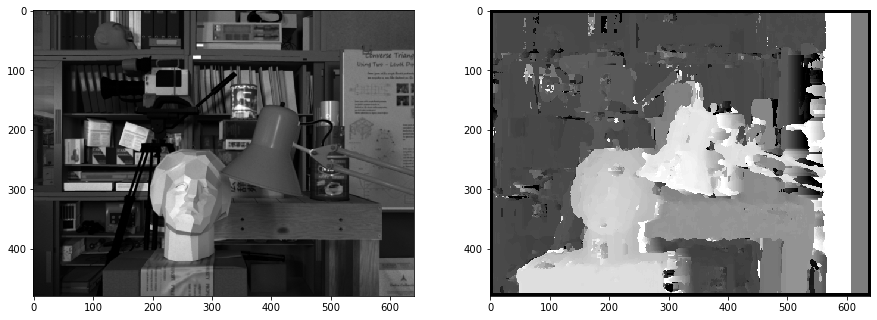

In [23]:
path_left = 'L1.png'
path_right = 'R1.png'

# load two pictures from the left camera and the right camera respectively as grayscale images
img_l = load_pic_as_gray(path_left)
img_r = load_pic_as_gray(path_right)

# set the range I mentioned in step 5
d = 80

# set the size of window (half of the width or height)
w_size = 5

# get disparity map
final_disparity = calculate_disparity_map(img_l, img_r, w_size, d)

# show result
fig = plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.imshow(img_l, cmap = 'gray')
plt.subplot(122)
plt.imshow(final_disparity, cmap='gray')
plt.show()

Look at the two picture above, the left one is the original picture and the right one is the disparity map. 

#### Projection

Now, we get disparity map, the next step is that we should project 2D points of disparity map into 3D space, so that we can get point cloud to build 3D model. And homogeneous coordinates can help us do this work. Homogeneous coordinate is to express a vector which is originally n dimension with an n + 1 dimension vector. It refers to a coordinate system used in projection geometry, just like Cartesian coordinate used in Euclidean geometry. We can add a w to the existing 2D coordinate to form a 2D homogeneous coordinate. Therefore, the Cartesian coordinate (X, Y) becomes (x, y, w). The corresponding relationship between X and Y in Cartesian coordinate and x and y in homogeneous coordinate can be expressed as follows: 

$$X = x / w, Y = y / w$$

So,

$$(X, Y) \Rightarrow (x/w, y/w, 1) $$

So there is a trick here, we can just add one more coordinate to form homogeneous image coordinate. In this case, we need 3D points:

$$(x, y, z) \Rightarrow (x, y, z, 1)$$

Next, we need to get the transformation matrix. This matrix is responsible for reprojecting depth and color into 3D space. And we can get depth from disparity map, so we can get the formulas:

$$(x, y, z, 1) = (x, y, disparityMap(x, y), 1)$$

Let me use Q to respresent transformation matrix:

$$(x, y, z, w) = Q * (x, y, z, 1)$$

$$\Rightarrow (x, y, z, w) = Q * (x, y, disparityMap(x, y), 1)$$

At last, we need to convert from homogeneous coordinate to Cartesian coordinate:

$$3dImage(x, y, z) = (x/w, y/w, z/w)$$

In [1]:
# project 2d points into 3d space
def projection(transformation_matrix, disparity_map):
    row, col = disparity_map.shape
    points_3d = np.zeros((row, col, 3))

    # use the formulas I mentioned above
    for r in range(row):
        for c in range(col):
            temp = np.dot(transformation_matrix, np.array([r, c, disparity_map[r, c], 1]))
            points_3d[r, c] = [temp[0]/temp[3], temp[1]/temp[3], temp[2]/temp[3]]
            
    return points_3d

I find a transformation matrix on the Internet to implement projection.

In [8]:
# set focal length
focal_length = 3.99

# in order to save time, I already save the disparity map to a picture.
disparity_map = load_pic('disparity_map.png')

# transformation matrix
Q = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, focal_length*0.05, 0], [0, 0, 0, 1]])

# get rid of points with value 0 that means no depth.
mask_map = disparity_map > disparity_map.min()

# get 3d points
points_3D = projection(Q, disparity_map)

imgL = load_pic('L1.png')
colors = imgL[:, :, :3]

# get colors and points.
output_points = points_3D[mask_map]
output_colors = colors[mask_map]

# show results
print('3d points')
print()
print(output_points)
print()
print('colors: \n')
print(output_colors)

3d points

[[   5.       -5.       15.3615]
 [   5.       -6.       15.3615]
 [   5.       -7.       15.3615]
 ...
 [ 474.     -632.       24.9375]
 [ 474.     -633.       24.9375]
 [ 474.     -634.       24.9375]]

colors: 

[[ 53  53  51]
 [ 55  54  52]
 [ 57  56  54]
 ...
 [ 65  89 101]
 [ 64  87 100]
 [ 68  87  97]]


#### Build point cloud file

We plan to use Meshlab to build show point cloud file. Meshlab is popular software that can read .ply files and show the data in 3d space. .ply is a computer file format with the full name of polygon file format or Stanford triangle Format. And the most important part of a .ply file is header. Header declares the data format and specifies points, patches and colors.
Look at the code below.

In [12]:
# generate .ply file
def create_ply(vertices, colors, filename):
    # set colors
    colors = colors.reshape(-1, 3)
    # set points
    vertices = np.hstack([vertices.reshape(-1, 3), colors])
    
    # we need to create a file first and then read it and insert the header into the file.
    np.savetxt(filename, vertices, fmt='%f %f %f %d %d %d') 
    
    # declare the data format
    ply_header = '''ply
            format ascii 1.0
            element vertex %(vert_num)d
            property float x
            property float y
            property float z
            property uchar red
            property uchar green
            property uchar blue
            end_header
            \n
            '''
    # generate .ply files
    with open(filename, 'r+') as f:
        old = f.read()
        f.seek(0)
        f.write(ply_header % dict(vert_num=len(vertices)))
        f.write(old)
    print('Successfully generated .Ply file')

In [13]:
file_name = 'model.ply'
create_ply(output_points, output_colors, file_name)

Successfully generated .Ply file
